# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "firas"
ln1 = "omrane"
fn2 = "ahlem"
ln2 = "jouidi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_omrane_firas_and_jouidi_ahlem.ipynb


In [0]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy
from scipy.optimize import check_grad
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Parameters / Coefficients')

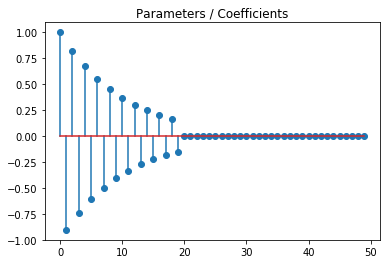

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [0]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [0]:
A, b = simu_linreg(coefs);
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [0]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(np.abs(x)- lmbd, 0)
    return z

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = 1/(1+lmbd)*x
    return z

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.linalg.norm(x)

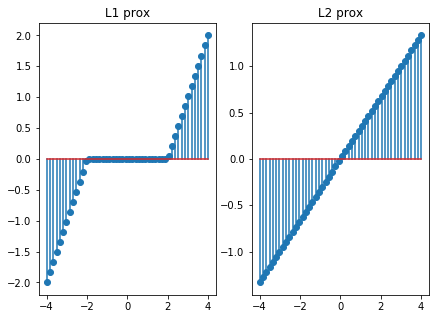

In [9]:
# Plots TODO
a = np.linspace(-4, 4)
lmbd = 2
fig, ax = plt.subplots(1, 2, figsize = (7, 5))
ax[0].stem(a, prox_L1(a, lmbd))
ax[0].set_title('L1 prox')
ax[1].stem(a, prox_L2(a, lmbd))
ax[1].set_title('L2 prox')
plt.show()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

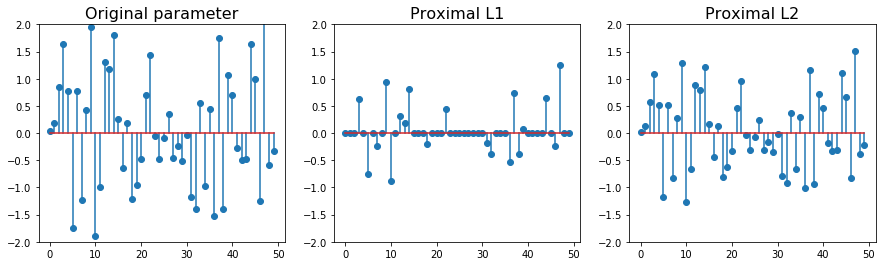

In [10]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])
plt.show()

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

The Proximal Lasso induces sparsity on the coefficients.Indeed, it tends to penalize weights with an absolute value higher than l_l2 and shrinks the other coefs with a factor of lmbd.
On the other hand, the Proximal Ridge attempts to make weights as small as possible by multiplying them using the factor $\frac{1}{1+lmbd}$.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [11]:
def loss_linreg(x):
    """Least squares loss"""
    n = A.shape[0]
    return 1/(2*n) *np.linalg.norm(b-np.dot(A,x))**2

def grad_linreg(x):
    """Least squares gradient"""
    n = A.shape[0]    
#     if(np.array(x).all() == 0):
#         return (1./n)* (-A.T @ b)
#     return  (A.T @ (A@x -b))
    return (1./n)* np.dot(A.T,np.dot(A,x)-b)

def loss_logreg(x):
    """Logistic loss"""
    n = A.shape[0]
#     return (1./n) * np.log(1 + np.exp(-b.T @ (A@x) ))
    return (1./ n)*np.sum(np.log(1+np.exp(-b*(A.dot(x)))))

def grad_logreg(x):
    """Logistic gradient"""
    n = A.shape[0]

#     result =  (1./n) * A.T @ (b/(1 + np.exp(b.T @ (A@x) )))
    return -(1./n) * A.T.dot(b*(1./(1.+np.exp(b * A.dot(x)))))

# TO BE COMPLETED
A, b = simu_linreg(coefs);
d = A.shape[1]
x = np.random.randn(d)

print('least squares loss of the coefs: ',loss_linreg(coefs))
# print('linreg grad: ', grad_linreg(x))

print('checking grad linreg: ',check_grad(loss_linreg, grad_linreg, x))


least squares loss of the coefs:  0.5075570401887747
checking grad linreg:  2.5758756771040863e-06


In [12]:
A, b = simu_logreg(coefs);
d = A.shape[1]
x = np.random.randn(d)
print('logistic loss of the coefs: ',loss_logreg(coefs))
# print('logreg grad: ', grad_logreg(x))

print('checking grad logreg: ',check_grad(loss_logreg, grad_logreg, x))

logistic loss of the coefs:  0.5053698928456597
checking grad logreg:  1.3244040545684383e-07


After checking the gradients the implementation seems correct.

## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [0]:
# TO BE COMPLETED

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""   
    l=1/n_samples*(np.linalg.norm(A,ord=2))**2
    # TODO
    return l
# Calculate the smoothness constant for logistic loss    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""  
    l=1/(4*n_samples)*(np.linalg.norm(A,ord=2))**2
    # TODO
    return l
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd, n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = np.array(x0.copy())
    n_samples, n_features = A.shape
    lmbda=lmbd
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbda)
    
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
     
    
    for k in range(n_iter ):
      
      tmp=x-step*grad_f(x)
    
     
      x=prox_R(tmp, lmbd*step)
      
      
      obj = f(x) + R(x, lmbda)
      err = norm(x - x_true) / norm(x_true)
      errors.append(err)
      objectives.append(obj)
      if k % 10 == 0 and verbose:
       
        print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [0]:
# TO BE COMPLETED


def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    lmbda=lmbd
    obj = f(x) + R(x, lmbda)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    w=np.array(x0.copy())
    beta=1
    
    for k in range(n_iter ):
      w1= np.array(prox_R(z-step*grad_f(z),lmbd*step))
      beta1=(1+np.sqrt(1+4*beta**2))/2
      z=w1+(beta-1)/beta1*(w1-w)
      beta=beta1
      w=w1
      x=w
        #### TODO ####

      obj = f(x) + R(x, lmbda)
      err = norm(x - x_true) / norm(x_true)
      errors.append(err)
      objectives.append(obj)
      if k % 10 == 0 and verbose:
        print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [0]:

x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

step=1/smoothness_const_linreg(A)
x_min , obj_min, _ = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,lmbd,n_iter,x_true=coefs, verbose=False)

In [0]:

A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 100
lmbd = 1e-2
step=1/smoothness_const_linreg(A)


x_min_PGD_l1, obj_min_PGD_l1, err_min_PGD_l1 = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)
x_min_APGD_l1 , obj_min_APGD_l1, err_min_APGD_l1 = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)
x_min_PGD_l2, obj_min_PGD_l2, err_min_PGD_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,lmbd,n_iter,x_true=x_min, verbose=False)
x_min_APGD_l2 , obj_min_APGD_l2, err_min_APGD_l2 = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,lmbd,n_iter,x_true=x_min, verbose=False)


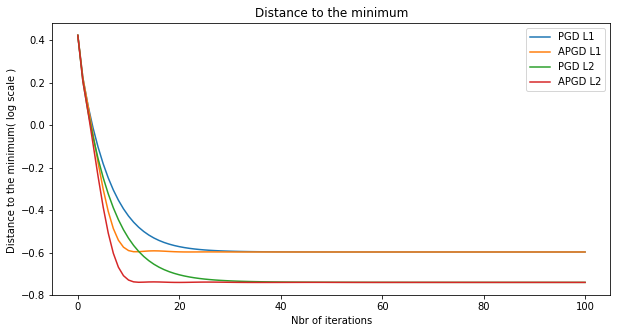

In [17]:
plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_min_PGD_l1),label = "PGD L1")
plt.plot(range(n_iter+1),np.log(obj_min_APGD_l1),label = "APGD L1")
plt.plot(range(n_iter+1),np.log(obj_min_PGD_l2),label = "PGD L2")
plt.plot(range(n_iter+1),np.log(obj_min_APGD_l2),label = "APGD L2")
plt.title("Distance to the minimum")
plt.xlabel("Nbr of iterations")
plt.ylabel("Distance to the minimum log scale ")
plt.legend()
plt.show()

The APGD converges faster to the minimum when compared to the PGD 

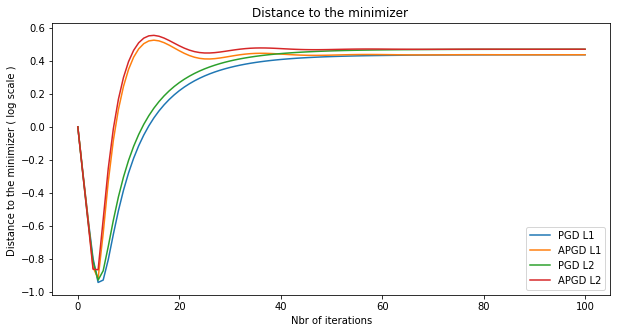

In [18]:
# Comparaison of the distance to the minimizer
plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(err_min_PGD_l1),label = "PGD L1")
plt.plot(range(n_iter+1),np.log(err_min_APGD_l1),label = "APGD L1")
plt.plot(range(n_iter+1),np.log(err_min_PGD_l2),label = "PGD L2")
plt.plot(range(n_iter+1),np.log(err_min_APGD_l2),label = "APGD L2")
plt.title("Distance to the minimizer ")
plt.xlabel("Nbr of iterations")
plt.ylabel("Distance to the minimizer ( log scale ) ")
plt.legend()
plt.show()

The APGD converges to the minimizer faster than PGD for both L1 and L2

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

### Compare the solution you obtain with ista and fista with the true parameter `coefs` of the model. This can be done with `plt.stem` plots.

<StemContainer object of 3 artists>

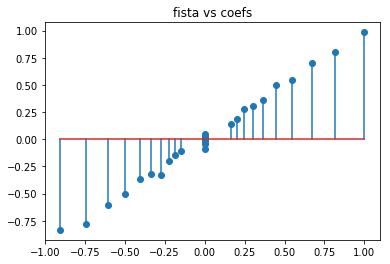

In [27]:
plt.title ("fista vs coefs" )
plt.stem(coefs,x_min_APGD_l1)

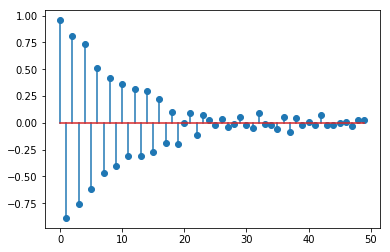

In [28]:
plt.stem(x)
plt.show()

the stem plots give the images that are very close to y = x which means for both fista and ista we are getting very close to the real minimizer coefs.

### In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.

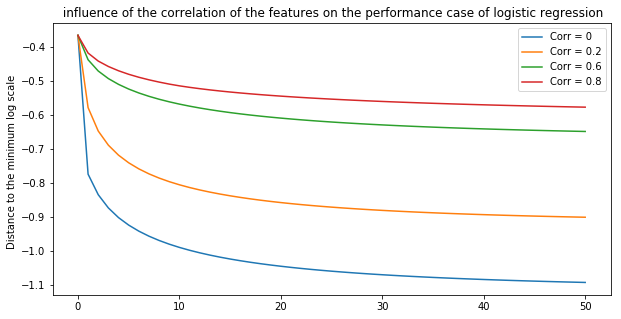

In [21]:
x0 = np.zeros(n_features)
n_iter = 50
lmbd = 1e-2
step=1. / smoothness_const_linreg(A)
A, b = simu_linreg(coefs,corr=0);
x_PGD_l1, obj_PGD_l1_0, err_PGD_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)

A, b = simu_linreg(coefs,corr=0.2);
x_PGD_l1, obj_PGD_l1_20, err_PGD_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)

A, b = simu_linreg(coefs,corr=0.6);
x_PGD_l1, obj_PGD_l1_60, err_PGD_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)

A, b = simu_linreg(coefs,corr=0.8);
x_PGD_l1, obj_PGD_l1_80, err_PGD_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step,lmbd,n_iter,x_true=x_min, verbose=False)

plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_PGD_l1_0),label = "Corr = 0")
plt.plot(range(n_iter+1),np.log(obj_PGD_l1_20),label = "Corr = 0.2")
plt.plot(range(n_iter+1),np.log(obj_PGD_l1_60),label = "Corr = 0.6")
plt.plot(range(n_iter+1),np.log(obj_PGD_l1_80),label = "Corr = 0.8")
plt.title(" influence of the correlation of the features on the performance case of logistic regression")

plt.ylabel("Distance to the minimum log scale  ")
plt.legend()


Linear regression and logistic regression estimates tend to have low bias and high variance. and this is especially the case if there are many predictive features in the model or if they are highly correlated with each other. So the less correlated the parameters the faster the model converges,the gradient descent is supposed to calculate the gradient in every direction and since the data is correlated the gradient will be the same in the correlated directions which will make the convergence slower.

### In linear regression and logistic regression, study the influence of the level of L2 penalization on the performance of the optimization algorithms. Explain.

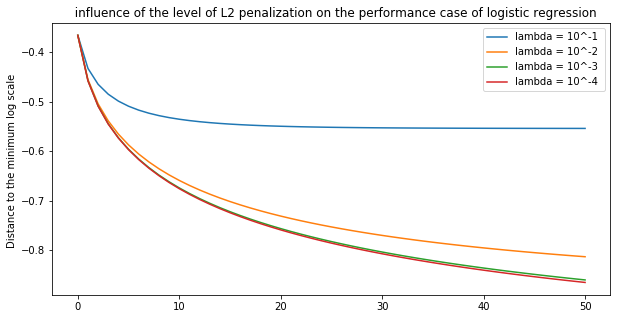

In [22]:
#initialization
A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 50
step=1./smoothness_const_linreg(A)


x, obj_l2_1, err_l2 = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2,step,0.1,n_iter,x_true=x_min, verbose=False)

x , obj_l2_2, err_l2 = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2,step,0.01,n_iter,x_true=x_min, verbose=False)


x, obj_l2_3, err_l2 = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2,step,0.001,n_iter,x_true=x_min, verbose=False)

x , obj_l2_4, err_l2 = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2,step,0.0001,n_iter,x_true=x_min, verbose=False)

plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_l2_1),label = "lambda = 10^-1")
plt.plot(range(n_iter+1),np.log(obj_l2_2),label = "lambda = 10^-2 ")
plt.plot(range(n_iter+1),np.log(obj_l2_3),label = "lambda = 10^-3")
plt.plot(range(n_iter+1),np.log(obj_l2_4),label = "lambda = 10^-4")
plt.title("  influence of the level of L2 penalization on the performance case of logistic regression")
plt.ylabel("Distance to the minimum log scale ")
plt.legend()


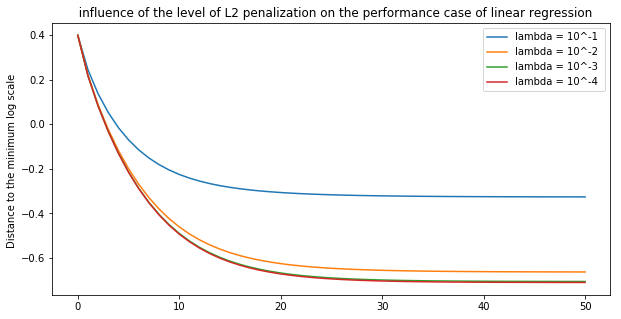

In [23]:

A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 50
step=1./smoothness_const_linreg(A)

x, obj_l2_1, err_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,0.1,n_iter,x_true=x_min, verbose=False)

x , obj_l2_2, err_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,0.01,n_iter,x_true=x_min, verbose=False)
x, obj_l2_3, err_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,0.001,n_iter,x_true=x_min, verbose=False)
x , obj_l2_4, err_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,0.0001,n_iter,x_true=x_min, verbose=False)

plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_l2_1),label = "lambda = 10^-1")
plt.plot(range(n_iter+1),np.log(obj_l2_2),label = "lambda = 10^-2 ")
plt.plot(range(n_iter+1),np.log(obj_l2_3),label = "lambda = 10^-3")
plt.plot(range(n_iter+1),np.log(obj_l2_4),label = "lambda = 10^-4")
plt.title("  influence of the level of L2 penalization on the performance case of linear regression")
plt.ylabel("Distance to the minimum log scale ")
plt.legend()



To overcome the problem of correlation between features and high variance, L2 regularization come. it allow to reduce the variance at the cost of introducing some bias, ultimately reducing the total error of the model. it penalizes the coefficients to shrink them towards zero. Not exactly zero, as that would mean exlusion from the model, but in the direction of zero, which can be viewed as decreasing model’s complexity in a continuous way, while keeping all variables in the model.

### In linear regression and logistic regression, compare the performance of the optimization algorithms for L2 and L1 penalizations. Explain

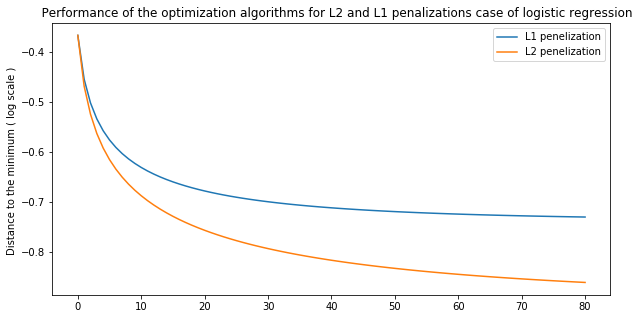

In [24]:

A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 80
step=1./smoothness_const_linreg(A)
lmbda = 0.01
x_l1, obj_l1, err_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step,lmbda,n_iter,x_true=x_min, verbose=False)

x_l2 , obj_l2, err_l2 = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2,step,lmbda,n_iter,x_true=x_min, verbose=False)
plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_l1),label = "L1 penelization")
plt.plot(range(n_iter+1),np.log(obj_l2),label = "L2 penelization")

plt.title("   Performance of the optimization algorithms for L2 and L1 penalizations case of logistic regression")
plt.ylabel("Distance to the minimum ( log scale ) ")
plt.legend()

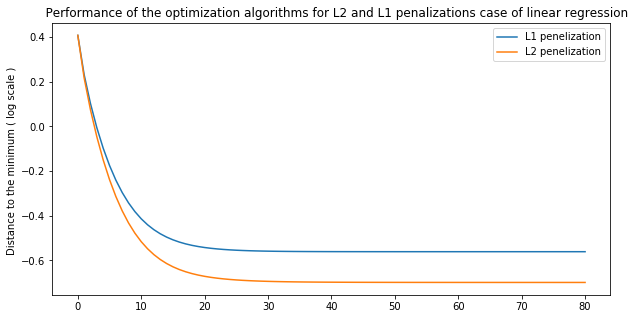

In [25]:
A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 80
step=1./smoothness_const_linreg(A)
lmbda = 0.01
x_l1, obj_l1, err_l1 = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1,step,lmbda,n_iter,x_true=x_min, verbose=False)

x_l2 , obj_l2, err_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step,lmbda,n_iter,x_true=x_min, verbose=False)
plt.figure(figsize=(10,5))
plt.plot(range(n_iter+1),np.log(obj_l1),label = "L1 penelization")
plt.plot(range(n_iter+1),np.log(obj_l2),label = "L2 penelization")

plt.title("   Performance of the optimization algorithms for L2 and L1 penalizations case of linear regression")
plt.ylabel("Distance to the minimum ( log scale ) ")
plt.legend()


LASSO also adds a penalty for non-zero coefficients to the loss function, but unlike Ridge Regression which penalizes sum of squared coefficients, L1 penality penalizes the sum of their absolute values. As a result, for high values of λ, many coefficients are exactly zeroed under LASSO, which is never the case in Ridge Regression.
As conclusion, Ridge Regression is expected to work better if there are many large parameters of about the same value, i.e. when most predictors truly impact the response. LASSO, on the other hand, is expected to come on top when there are a small number of significant parameters and the others are close to zero, i.e. when only a few predictors actually influence the response.